# Star Wars Data Analysis

## Setup imports and dataframes

In [148]:
# Import necessary libraries for dataframes, HTTP requests, JSON, and charts

import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [149]:
# Set the URLs for the APIs for each category SWAPI provides

films_url = "https://swapi.tech/api/films/"
people_url = "https://swapi.tech/api/people/"
planets_url = "https://swapi.tech/api/planets/"
species_url = "https://swapi.tech/api/species/"
starships_url = "https://swapi.tech/api/starships/"
vehicles_url = "https://swapi.tech/api/vehicles/"

In [150]:
# Retrieve the limit each category has for API requests

def retrieve_limit(url):
    response = requests.get(url)
    data = response.json()
    
    total_records = 10
    try:
        total_records = data["total_records"]
    except:
        pass

    return total_records

In [151]:
# Get the limits for each category

films_limit = retrieve_limit(films_url)
people_limit = retrieve_limit(people_url)  
planets_limit = retrieve_limit(planets_url)
species_limit = retrieve_limit(species_url)
starships_limit = retrieve_limit(starships_url)
vehicles_limit = retrieve_limit(vehicles_url)

print(f"The number of films is {films_limit}")
print(f"The number of people is {people_limit}")
print(f"The number of planets is {planets_limit}")
print(f"The number of species is {species_limit}")
print(f"The number of starships is {starships_limit}")
print(f"The number of vehicles is {vehicles_limit}")

The number of films is 10
The number of people is 82
The number of planets is 60
The number of species is 37
The number of starships is 36
The number of vehicles is 39


In [152]:
# Get JSON for total records in each category

films_json = requests.get(f"{films_url}?page=1&limit={films_limit}").json()
people_json = requests.get(f"{people_url}?page=1&limit={people_limit}").json()
planets_json = requests.get(f"{planets_url}?page=1&limit={planets_limit}").json()
species_json = requests.get(f"{species_url}?page=1&limit={species_limit}").json()
starships_json = requests.get(f"{starships_url}?page=1&limit={starships_limit}").json()
vehicles_json = requests.get(f"{vehicles_url}?page=1&limit={vehicles_limit}").json()

In [153]:
!pip install asyncio
!pip install aiohttp

In [154]:
# Loop through each url in people, planets, species, starships, and vehicles to get the data
# because the initial requests refer to URLs for each individual entry and we need that data

import asyncio
import aiohttp

# Function to fetch data from a URL asynchronously, reducing response time by about 40% from synchronously  
async def fetch(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            return await response.json()

# Function to get data for each category
async def get_data(category_json):
    data = []
    print(f"{category_json['total_records']} records found - looping through {len(category_json['results'])} records")
    for entry in category_json["results"]:
        entry_json = await fetch(entry["url"])
        data.append(entry_json['result']['properties'])
    print(f"Finished processing {len(data)} records")
    return data

# Run the async tasks
results = await asyncio.gather(
    get_data(people_json),
    get_data(planets_json),
    get_data(species_json),
    get_data(starships_json),
    get_data(vehicles_json)
)

people_data, planets_data, species_data, starships_data, vehicles_data = results

82 records found - looping through 82 records
60 records found - looping through 60 records
37 records found - looping through 37 records
36 records found - looping through 36 records
39 records found - looping through 39 records
Finished processing 37 records
Finished processing 36 records
Finished processing 39 records
Finished processing 60 records
Finished processing 82 records


In [155]:
# Function that updates the JSON with the data retrieved
def update_json(category_json, data):
    print(f"Reconciling {len(category_json['results'])} records with data retrieved from {len(data)} records")
    for i in range(0, len(category_json["results"])):
        category_json["results"][i].update(data[i])
    return category_json

In [156]:
# Update each category's JSON with the data retrieved
people_json = update_json(people_json, people_data)
planets_json = update_json(planets_json, planets_data)
species_json = update_json(species_json, species_data)
starships_json = update_json(starships_json, starships_data)
vehicles_json = update_json(vehicles_json, vehicles_data)

Reconciling 82 records with data retrieved from 82 records
Reconciling 60 records with data retrieved from 60 records
Reconciling 37 records with data retrieved from 37 records
Reconciling 36 records with data retrieved from 36 records
Reconciling 39 records with data retrieved from 39 records


In [157]:
# Create dataframes for each category
# Need to explode the arrays in films_df to get the data in a usable format
films_df = pd.json_normalize([item["properties"] for item in films_json["result"]]).explode("characters").explode("planets").explode("species").explode("starships").explode("vehicles")    
people_df = pd.DataFrame(people_json["results"])
planets_df = pd.DataFrame(planets_json["results"])
# Explode all arrays for easier joins
species_df = pd.DataFrame(species_json["results"]).explode("people")
starships_df = pd.DataFrame(starships_json["results"]).explode("pilots")
vehicles_df = pd.DataFrame(vehicles_json["results"]).explode("pilots")

# Display the first 5 rows of each dataframe
display(films_df.head())
display(people_df.head())
display(planets_df.head())
display(species_df.head())
display(starships_df.head())
display(vehicles_df.head())

,characters,planets,starships,vehicles,species,created,edited,producer,title,episode_id,director,release_date,opening_crawl,url
0,https://www.swapi.tech/api/people/1,https://www.swapi.tech/api/planets/1,https://www.swapi.tech/api/starships/2,https://www.swapi.tech/api/vehicles/4,https://www.swapi.tech/api/species/1,2025-01-27T10:26:01.964Z,2025-01-27T10:26:01.964Z,"Gary Kurtz, Rick McCallum",A New Hope,4,George Lucas,1977-05-25,It is a period of civil war.\r\nRebel spaceshi...,https://www.swapi.tech/api/films/1
0,https://www.swapi.tech/api/people/1,https://www.swapi.tech/api/planets/1,https://www.swapi.tech/api/starships/2,https://www.swapi.tech/api/vehicles/6,https://www.swapi.tech/api/species/1,2025-01-27T10:26:01.964Z,2025-01-27T10:26:01.964Z,"Gary Kurtz, Rick McCallum",A New Hope,4,George Lucas,1977-05-25,It is a period of civil war.\r\nRebel spaceshi...,https://www.swapi.tech/api/films/1
0,https://www.swapi.tech/api/people/1,https://www.swapi.tech/api/planets/1,https://www.swapi.tech/api/starships/2,https://www.swapi.tech/api/vehicles/7,https://www.swapi.tech/api/species/1,2025-01-27T10:26:01.964Z,2025-01-27T10:26:01.964Z,"Gary Kurtz, Rick McCallum",A New Hope,4,George Lucas,1977-05-25,It is a period of civil war.\r\nRebel spaceshi...,https://www.swapi.tech/api/films/1
0,https://www.swapi.tech/api/people/1,https://www.swapi.tech/api/planets/1,https://www.swapi.tech/api/starships/2,https://www.swapi.tech/api/vehicles/8,https://www.swapi.tech/api/species/1,2025-01-27T10:26:01.964Z,2025-01-27T10:26:01.964Z,"Gary Kurtz, Rick McCallum",A New Hope,4,George Lucas,1977-05-25,It is a period of civil war.\r\nRebel spaceshi...,https://www.swapi.tech/api/films/1
0,https://www.swapi.tech/api/people/1,https://www.swapi.tech/api/planets/1,https://www.swapi.tech/api/starships/3,https://www.swapi.tech/api/vehicles/4,https://www.swapi.tech/api/species/1,2025-01-27T10:26:01.964Z,2025-01-27T10:26:01.964Z,"Gary Kurtz, Rick McCallum",A New Hope,4,George Lucas,1977-05-25,It is a period of civil war.\r\nRebel spaceshi...,https://www.swapi.tech/api/films/1


,uid,name,url,height,mass,hair_color,skin_color,eye_color,birth_year,gender,created,edited,homeworld
0,1,Luke Skywalker,https://www.swapi.tech/api/people/1,172,77,blond,fair,blue,19BBY,male,2025-01-27T10:26:01.973Z,2025-01-27T10:26:01.973Z,https://www.swapi.tech/api/planets/1
1,2,C-3PO,https://www.swapi.tech/api/people/2,167,75,n/a,gold,yellow,112BBY,n/a,2025-01-27T10:26:01.973Z,2025-01-27T10:26:01.973Z,https://www.swapi.tech/api/planets/1
2,3,R2-D2,https://www.swapi.tech/api/people/3,96,32,n/a,"white, blue",red,33BBY,n/a,2025-01-27T10:26:01.973Z,2025-01-27T10:26:01.973Z,https://www.swapi.tech/api/planets/8
3,4,Darth Vader,https://www.swapi.tech/api/people/4,202,136,none,white,yellow,41.9BBY,male,2025-01-27T10:26:01.973Z,2025-01-27T10:26:01.973Z,https://www.swapi.tech/api/planets/1
4,5,Leia Organa,https://www.swapi.tech/api/people/5,150,49,brown,light,brown,19BBY,female,2025-01-27T10:26:01.973Z,2025-01-27T10:26:01.973Z,https://www.swapi.tech/api/planets/2


,uid,name,url,diameter,rotation_period,orbital_period,gravity,population,climate,terrain,surface_water,created,edited
0,1,Tatooine,https://www.swapi.tech/api/planets/1,10465,23,304,1 standard,200000,arid,desert,1,2025-01-27T10:26:01.976Z,2025-01-27T10:26:01.976Z
1,2,Alderaan,https://www.swapi.tech/api/planets/2,12500,24,364,1 standard,2000000000,temperate,"grasslands, mountains",40,2025-01-27T10:26:01.976Z,2025-01-27T10:26:01.976Z
2,3,Yavin IV,https://www.swapi.tech/api/planets/3,10200,24,4818,1 standard,1000,"temperate, tropical","jungle, rainforests",8,2025-01-27T10:26:01.976Z,2025-01-27T10:26:01.976Z
3,4,Hoth,https://www.swapi.tech/api/planets/4,7200,23,549,1.1 standard,unknown,frozen,"tundra, ice caves, mountain ranges",100,2025-01-27T10:26:01.976Z,2025-01-27T10:26:01.976Z
4,5,Dagobah,https://www.swapi.tech/api/planets/5,8900,23,341,N/A,unknown,murky,"swamp, jungles",8,2025-01-27T10:26:01.976Z,2025-01-27T10:26:01.976Z


,uid,name,url,classification,designation,average_height,average_lifespan,hair_colors,skin_colors,eye_colors,homeworld,language,people,created,edited
0,1,Human,https://www.swapi.tech/api/species/1,mammal,sentient,180,120,"blonde, brown, black, red","caucasian, black, asian, hispanic","brown, blue, green, hazel, grey, amber",https://www.swapi.tech/api/planets/1,Galactic Basic,https://www.swapi.tech/api/people/66,2025-01-27T10:26:01.978Z,2025-01-27T10:26:01.978Z
0,1,Human,https://www.swapi.tech/api/species/1,mammal,sentient,180,120,"blonde, brown, black, red","caucasian, black, asian, hispanic","brown, blue, green, hazel, grey, amber",https://www.swapi.tech/api/planets/1,Galactic Basic,https://www.swapi.tech/api/people/67,2025-01-27T10:26:01.978Z,2025-01-27T10:26:01.978Z
0,1,Human,https://www.swapi.tech/api/species/1,mammal,sentient,180,120,"blonde, brown, black, red","caucasian, black, asian, hispanic","brown, blue, green, hazel, grey, amber",https://www.swapi.tech/api/planets/1,Galactic Basic,https://www.swapi.tech/api/people/68,2025-01-27T10:26:01.978Z,2025-01-27T10:26:01.978Z
0,1,Human,https://www.swapi.tech/api/species/1,mammal,sentient,180,120,"blonde, brown, black, red","caucasian, black, asian, hispanic","brown, blue, green, hazel, grey, amber",https://www.swapi.tech/api/planets/1,Galactic Basic,https://www.swapi.tech/api/people/74,2025-01-27T10:26:01.978Z,2025-01-27T10:26:01.978Z
1,2,Droid,https://www.swapi.tech/api/species/2,artificial,sentient,n/a,indefinite,n/a,n/a,n/a,https://www.swapi.tech/api/planets/2,n/a,https://www.swapi.tech/api/people/2,2025-01-27T10:26:01.978Z,2025-01-27T10:26:01.978Z


,uid,name,url,model,starship_class,manufacturer,cost_in_credits,length,crew,passengers,max_atmosphering_speed,hyperdrive_rating,MGLT,cargo_capacity,consumables,pilots,created,edited
0,2,CR90 corvette,https://www.swapi.tech/api/starships/2,CR90 corvette,corvette,Corellian Engineering Corporation,3500000,150,30-165,600,950,2.0,60,3000000,1 year,NaN,2020-09-17T17:55:06.604Z,2020-09-17T17:55:06.604Z
1,3,Star Destroyer,https://www.swapi.tech/api/starships/3,Imperial I-class Star Destroyer,Star Destroyer,Kuat Drive Yards,150000000,"1,600","47,060",n/a,975,2.0,60,36000000,2 years,NaN,2020-09-17T17:55:06.604Z,2020-09-17T17:55:06.604Z
2,5,Sentinel-class landing craft,https://www.swapi.tech/api/starships/5,Sentinel-class landing craft,landing craft,"Sienar Fleet Systems, Cyngus Spaceworks",240000,38,5,75,1000,1.0,70,180000,1 month,NaN,2020-09-17T17:55:06.604Z,2020-09-17T17:55:06.604Z
3,9,Death Star,https://www.swapi.tech/api/starships/9,DS-1 Orbital Battle Station,Deep Space Mobile Battlestation,"Imperial Department of Military Research, Sien...",1000000000000,120000,"342,953","843,342",n/a,4.0,10,1000000000000,3 years,NaN,2020-09-17T17:55:06.604Z,2020-09-17T17:55:06.604Z
4,11,Y-wing,https://www.swapi.tech/api/starships/11,BTL Y-wing,assault starfighter,Koensayr Manufacturing,134999,14,2,0,1000km,1.0,80,110,1 week,NaN,2020-09-17T17:55:06.604Z,2020-09-17T17:55:06.604Z


,uid,name,url,model,vehicle_class,manufacturer,cost_in_credits,length,crew,passengers,max_atmosphering_speed,cargo_capacity,consumables,films,pilots,created,edited
0,4,Sand Crawler,https://www.swapi.tech/api/vehicles/4,Digger Crawler,wheeled,Corellia Mining Corporation,150000,36.8,46,30,30,50000,2 months,[],NaN,2020-09-17T17:46:31.415Z,2020-09-17T17:46:31.415Z
1,7,X-34 landspeeder,https://www.swapi.tech/api/vehicles/7,X-34 landspeeder,repulsorcraft,SoroSuub Corporation,10550,3.4,1,1,250,5,unknown,[],NaN,2020-09-17T17:46:31.415Z,2020-09-17T17:46:31.415Z
2,6,T-16 skyhopper,https://www.swapi.tech/api/vehicles/6,T-16 skyhopper,repulsorcraft,Incom Corporation,14500,10.4,1,1,1200,50,0,[],NaN,2020-09-17T17:46:31.415Z,2020-09-17T17:46:31.415Z
3,8,TIE/LN starfighter,https://www.swapi.tech/api/vehicles/8,Twin Ion Engine/Ln Starfighter,starfighter,Sienar Fleet Systems,unknown,6.4,1,0,1200,65,2 days,[],NaN,2020-09-17T17:46:31.415Z,2020-09-17T17:46:31.415Z
4,14,Snowspeeder,https://www.swapi.tech/api/vehicles/14,t-47 airspeeder,airspeeder,Incom corporation,unknown,4.5,2,0,650,10,none,[],https://www.swapi.tech/api/people/1,2020-09-17T17:46:31.415Z,2020-09-17T17:46:31.415Z


Graph Testing

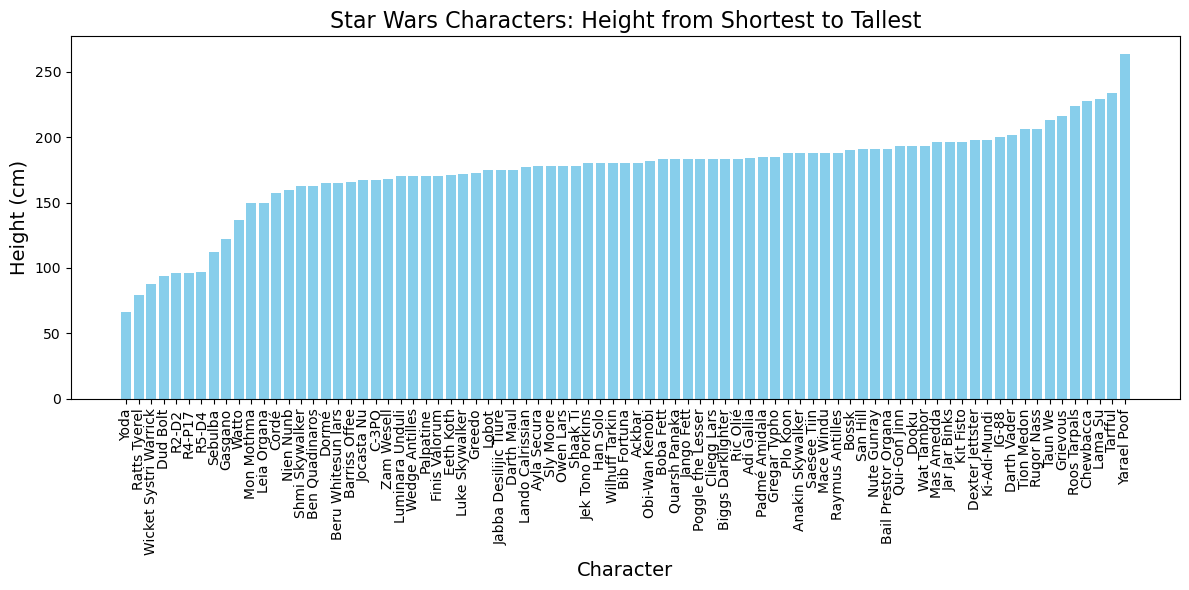

In [158]:
# Generic Chart by height
# Convert 'height' column to numeric, ignoring errors for non-numeric values
people_df['height'] = pd.to_numeric(people_df['height'], errors='coerce')

# Drop rows with missing or invalid height values
people_df_cleaned = people_df.dropna(subset=['height'])

# Sort by height
people_df_sorted = people_df_cleaned.sort_values(by='height')

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(people_df_sorted['name'], people_df_sorted['height'], color='skyblue')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Star Wars Characters: Height from Shortest to Tallest', fontsize=16)
plt.xlabel('Character', fontsize=14)
plt.ylabel('Height (cm)', fontsize=14)
plt.tight_layout()
plt.show()

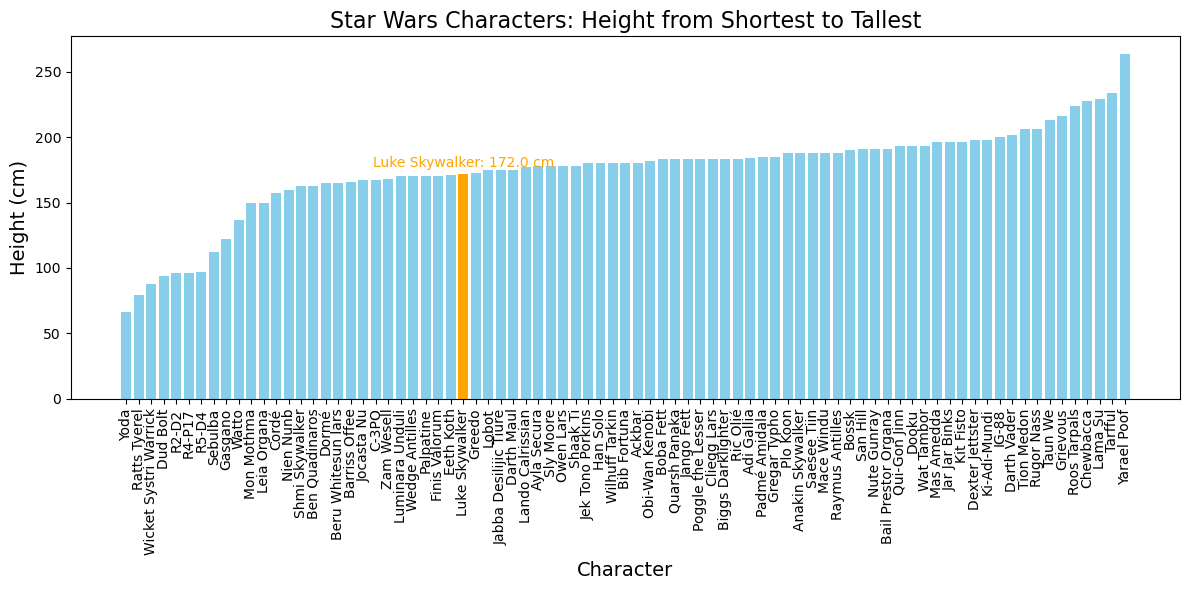

In [159]:
# Function to plot the graph and highlight a specific character


def plot_character_height(people_df, highlight_character=None):
    # Convert 'height' column to numeric, ignoring errors for non-numeric values
    people_df['height'] = pd.to_numeric(people_df['height'], errors='coerce')

    # Drop rows with missing or invalid height values
    people_df_cleaned = people_df.dropna(subset=['height'])

    # Sort by height
    people_df_sorted = people_df_cleaned.sort_values(by='height')

    # Assign colors: highlight one character differently
    colors = ['skyblue' if name != highlight_character else 'orange' for name in people_df_sorted['name']]

    # Create a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(people_df_sorted['name'], people_df_sorted['height'], color=colors)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.title('Star Wars Characters: Height from Shortest to Tallest', fontsize=16)
    plt.xlabel('Character', fontsize=14)
    plt.ylabel('Height (cm)', fontsize=14)

    # Add annotation if a character is highlighted
    if highlight_character and highlight_character in people_df_sorted['name'].values:
        char_height = people_df_sorted.loc[people_df_sorted['name'] == highlight_character, 'height'].values[0]
        plt.text(
            people_df_sorted['name'].tolist().index(highlight_character),
            char_height + 5,  # Position slightly above the bar
            f"{highlight_character}: {char_height} cm",
            ha='center', color='orange', fontsize=10
        )

    plt.tight_layout()
    plt.show()

# Example Usage: Highlight Luke Skywalker
plot_character_height(people_df, highlight_character='Luke Skywalker')

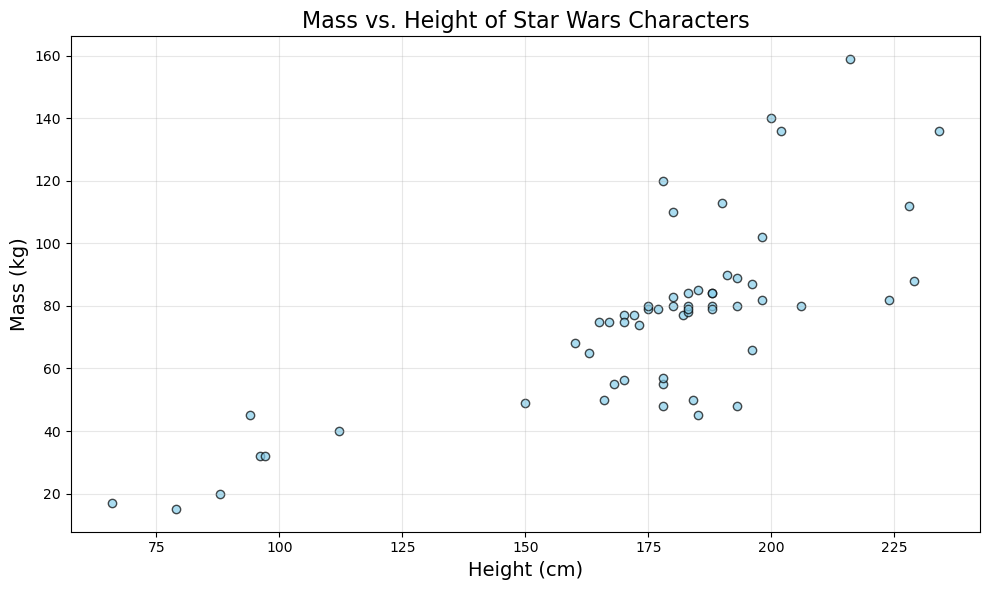

In [161]:
# Generic Scatter Chart for comparing Mass vs. Height of Star Wars Characters
# Load the data from the CSV file

# Convert 'mass' and 'height' columns to numeric, ignoring errors for non-numeric values
people_df['mass'] = pd.to_numeric(people_df['mass'], errors='coerce')
people_df['height'] = pd.to_numeric(people_df['height'], errors='coerce')

# Drop rows with missing or invalid values in 'mass' or 'height'
people_df_cleaned = people_df.dropna(subset=['mass', 'height'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(people_df_cleaned['height'], people_df_cleaned['mass'], color='skyblue', edgecolor='black', alpha=0.7)

# Add labels, title, and grid
plt.title('Mass vs. Height of Star Wars Characters', fontsize=16)
plt.xlabel('Height (cm)', fontsize=14)
plt.ylabel('Mass (kg)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

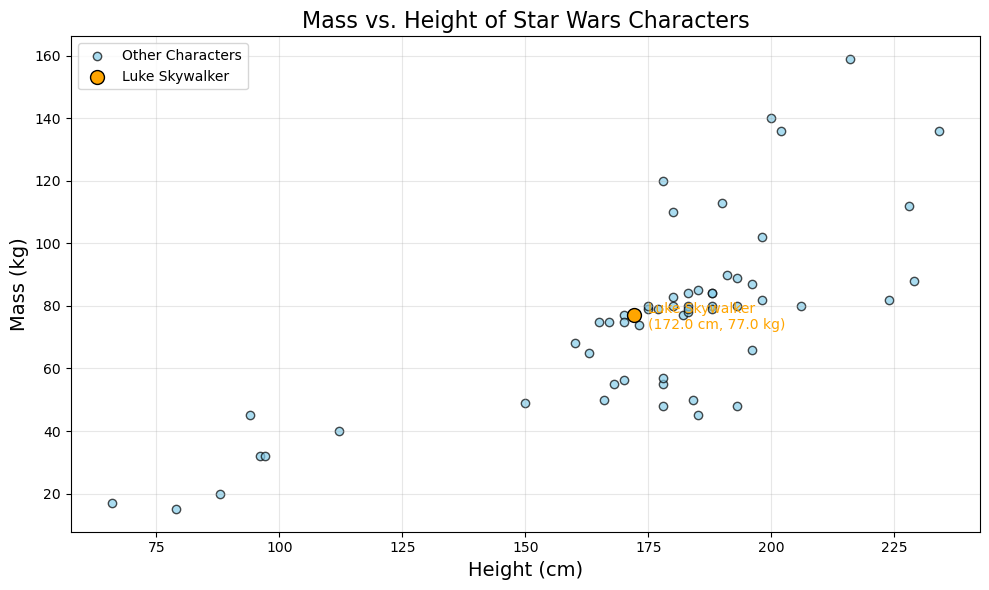

In [162]:


def plot_mass_vs_height(people_df, highlight_character=None):
    # Convert 'mass' and 'height' columns to numeric, ignoring errors for non-numeric values
    people_df['mass'] = pd.to_numeric(people_df['mass'], errors='coerce')
    people_df['height'] = pd.to_numeric(people_df['height'], errors='coerce')

    # Drop rows with missing or invalid values in 'mass' or 'height'
    people_df_cleaned = people_df.dropna(subset=['mass', 'height'])

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(
        people_df_cleaned['height'], 
        people_df_cleaned['mass'], 
        color='skyblue', 
        edgecolor='black', 
        alpha=0.7, 
        label='Other Characters'
    )

    # Highlight a specific character if provided
    if highlight_character and highlight_character in people_df_cleaned['name'].values:
        highlight_row = people_df_cleaned[people_df_cleaned['name'] == highlight_character]
        plt.scatter(
            highlight_row['height'], 
            highlight_row['mass'], 
            color='orange', 
            edgecolor='black', 
            s=100,  # Larger marker size for emphasis
            label=f'{highlight_character}'
        )
        # Add annotation for the highlighted character
        plt.annotate(
            f"{highlight_character}\n({highlight_row['height'].values[0]} cm, {highlight_row['mass'].values[0]} kg)",
            (highlight_row['height'].values[0], highlight_row['mass'].values[0]),
            textcoords="offset points",
            xytext=(10, -10),  # Offset for the annotation
            ha='left',
            fontsize=10,
            color='orange'
        )

    # Add labels, title, legend, and grid
    plt.title('Mass vs. Height of Star Wars Characters', fontsize=16)
    plt.xlabel('Height (cm)', fontsize=14)
    plt.ylabel('Mass (kg)', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example Usage: Highlight Luke Skywalker
plot_mass_vs_height(people_df, highlight_character='Luke Skywalker')

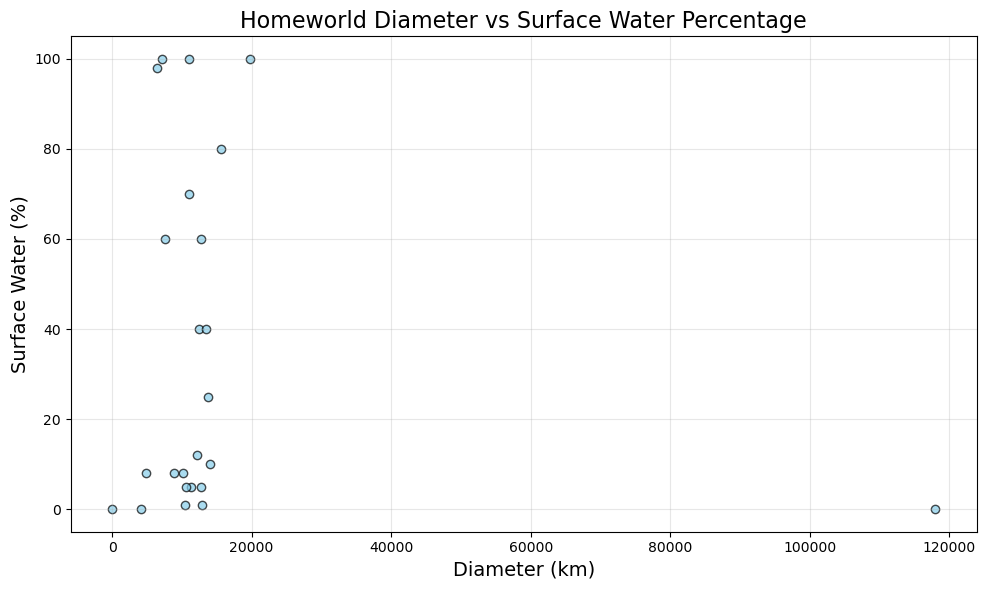

In [163]:
# Generic Scatter plot chart for comaparing Homeworld data vs surface water percentage
# Convert 'diameter' and 'surface_water' columns to numeric, ignoring errors for non-numeric values
planets_df['diameter'] = pd.to_numeric(planets_df['diameter'], errors='coerce')
planets_df['surface_water'] = pd.to_numeric(planets_df['surface_water'], errors='coerce')

# Drop rows with missing or invalid values in 'diameter' or 'surface_water'
planets_df_cleaned = planets_df.dropna(subset=['diameter', 'surface_water'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    planets_df_cleaned['diameter'], 
    planets_df_cleaned['surface_water'], 
    color='skyblue', 
    edgecolor='black', 
    alpha=0.7
)

# Add labels, title, and grid
plt.title('Homeworld Diameter vs Surface Water Percentage', fontsize=16)
plt.xlabel('Diameter (km)', fontsize=14)
plt.ylabel('Surface Water (%)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

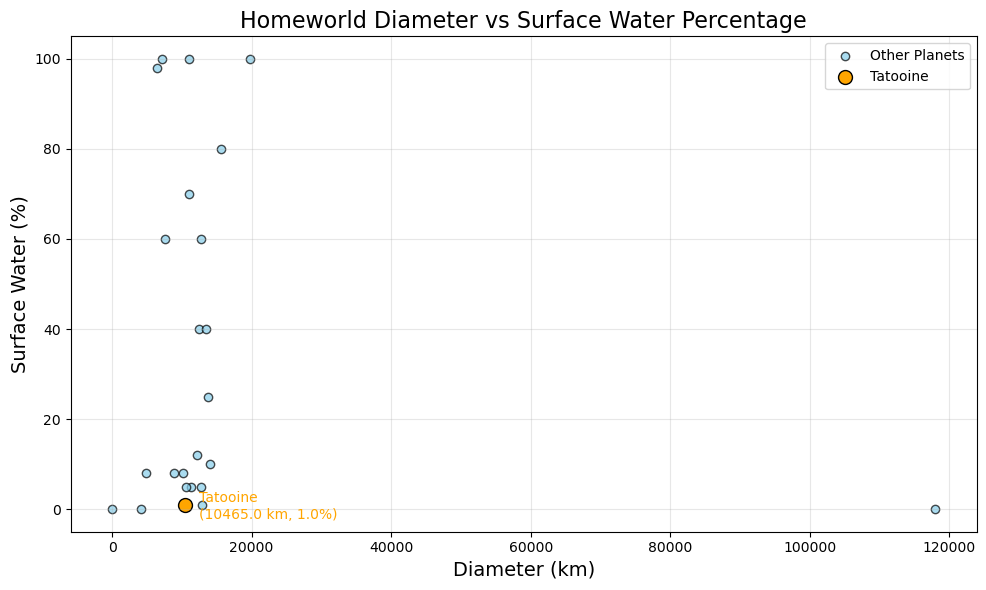

In [164]:


def plot_diameter_vs_surface_water(planets_df, highlight_planet=None):
    # Convert 'diameter' and 'surface_water' columns to numeric, ignoring errors for non-numeric values
    planets_df['diameter'] = pd.to_numeric(planets_df['diameter'], errors='coerce')
    planets_df['surface_water'] = pd.to_numeric(planets_df['surface_water'], errors='coerce')

    # Drop rows with missing or invalid values in 'diameter' or 'surface_water'
    planets_df_cleaned = planets_df.dropna(subset=['diameter', 'surface_water'])

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(
        planets_df_cleaned['diameter'], 
        planets_df_cleaned['surface_water'], 
        color='skyblue', 
        edgecolor='black', 
        alpha=0.7, 
        label='Other Planets'
    )

    # Highlight specific planet if provided
    if highlight_planet and highlight_planet in planets_df_cleaned['name'].values:
        highlight_row = planets_df_cleaned[planets_df_cleaned['name'] == highlight_planet]
        plt.scatter(
            highlight_row['diameter'], 
            highlight_row['surface_water'], 
            color='orange', 
            edgecolor='black', 
            s=100,  # Larger marker size for emphasis
            label=f'{highlight_planet}'
        )
        # Add annotation for the highlighted planet
        plt.annotate(
            f"{highlight_planet}\n({highlight_row['diameter'].values[0]} km, {highlight_row['surface_water'].values[0]}%)",
            (highlight_row['diameter'].values[0], highlight_row['surface_water'].values[0]),
            textcoords="offset points",
            xytext=(10, -10),  # Offset for the annotation
            ha='left',
            fontsize=10,
            color='orange'
        )

    # Add labels, title, legend, and grid
    plt.title('Homeworld Diameter vs Surface Water Percentage', fontsize=16)
    plt.xlabel('Diameter (km)', fontsize=14)
    plt.ylabel('Surface Water (%)', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example Usage: Highlight Tatooine
plot_diameter_vs_surface_water(planets_df, highlight_planet='Tatooine')

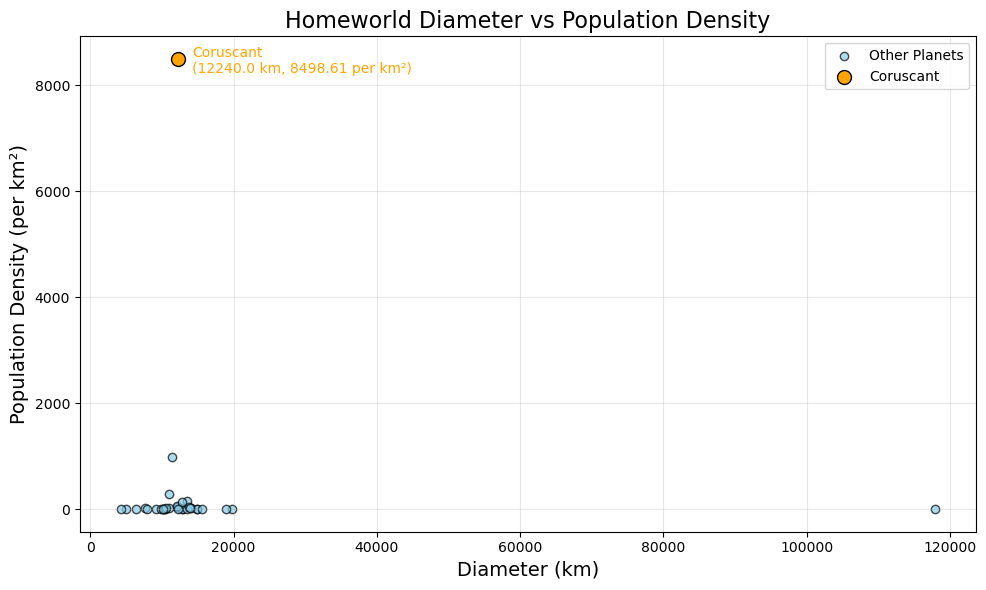

In [165]:
# Code for comparing planet diameter vs population

def plot_diameter_vs_population_density(planets_df, highlight_planet=None):
    # Convert 'diameter' and 'population' columns to numeric, ignoring errors for non-numeric values
    planets_df['diameter'] = pd.to_numeric(planets_df['diameter'], errors='coerce')
    planets_df['population'] = pd.to_numeric(planets_df['population'], errors='coerce')

    # Calculate population density (population per km² of diameter) and add it as a new column
    planets_df['population_density'] = planets_df['population'] / ((planets_df['diameter'] / 2) ** 2 * 3.14159)  # Area of a circle
    planets_df['population_density'] = planets_df['population_density'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values

    # Drop rows with missing or invalid values in 'diameter' or 'population_density'
    planets_df_cleaned = planets_df.dropna(subset=['diameter', 'population_density'])

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(
        planets_df_cleaned['diameter'], 
        planets_df_cleaned['population_density'], 
        color='skyblue', 
        edgecolor='black', 
        alpha=0.7, 
        label='Other Planets'
    )

    # Highlight specific planet if provided
    if highlight_planet and highlight_planet in planets_df_cleaned['name'].values:
        highlight_row = planets_df_cleaned[planets_df_cleaned['name'] == highlight_planet]
        plt.scatter(
            highlight_row['diameter'], 
            highlight_row['population_density'], 
            color='orange', 
            edgecolor='black', 
            s=100,  # Larger marker size for emphasis
            label=f'{highlight_planet}'
        )
        # Add annotation for the highlighted planet
        plt.annotate(
            f"{highlight_planet}\n({highlight_row['diameter'].values[0]} km, {highlight_row['population_density'].values[0]:.2f} per km²)",
            (highlight_row['diameter'].values[0], highlight_row['population_density'].values[0]),
            textcoords="offset points",
            xytext=(10, -10),  # Offset for the annotation
            ha='left',
            fontsize=10,
            color='orange'
        )

    # Add labels, title, legend, and grid
    plt.title('Homeworld Diameter vs Population Density', fontsize=16)
    plt.xlabel('Diameter (km)', fontsize=14)
    plt.ylabel('Population Density (per km²)', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example Usage: Highlight Coruscant
plot_diameter_vs_population_density(planets_df, highlight_planet='Coruscant')

C:\Users\jesseparent\AppData\Local\Temp\ipykernel_7880\1702098666.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_df_cleaned['type_numeric'] = species_df_cleaned['classification'].map(type_mapping)


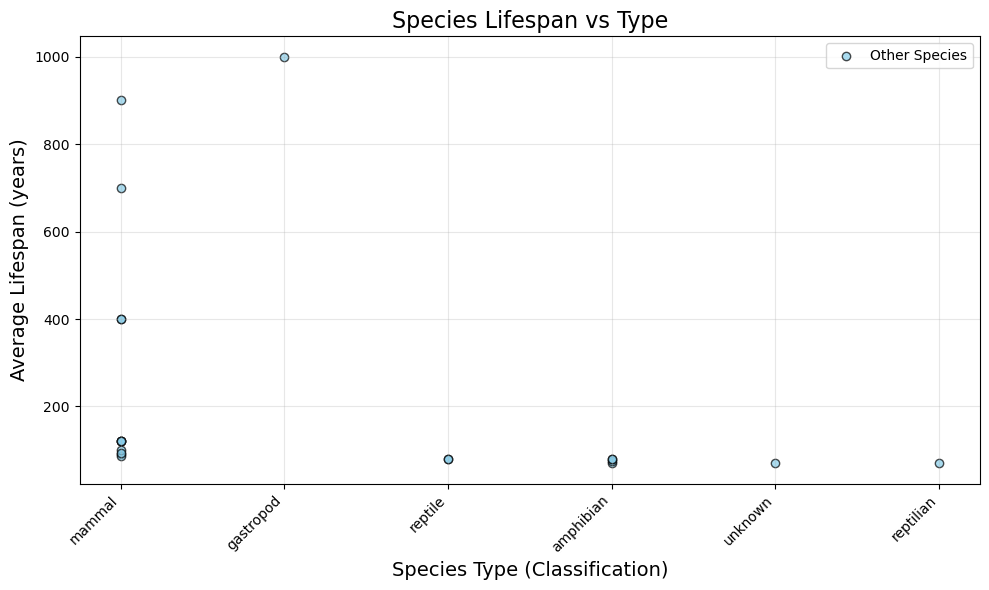

In [166]:
def plot_lifespan_vs_type(species_df, highlight_species=None):
    # Convert 'average_lifespan' to numeric, ignoring errors for non-numeric values
    species_df['average_lifespan'] = pd.to_numeric(species_df['average_lifespan'], errors='coerce')

    # Drop rows with missing or invalid values in 'average_lifespan' or 'classification'
    species_df_cleaned = species_df.dropna(subset=['average_lifespan', 'classification'])

    # Assign unique numeric values to each species type (classification) for the x-axis
    type_mapping = {t: i for i, t in enumerate(species_df_cleaned['classification'].unique())}
    species_df_cleaned['type_numeric'] = species_df_cleaned['classification'].map(type_mapping)

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(
        species_df_cleaned['type_numeric'], 
        species_df_cleaned['average_lifespan'], 
        color='skyblue', 
        edgecolor='black', 
        alpha=0.7, 
        label='Other Species'
    )

    # Add x-axis labels corresponding to species type
    plt.xticks(
        ticks=list(type_mapping.values()),
        labels=list(type_mapping.keys()),
        rotation=45,
        ha='right'
    )

    # Highlight specific species if provided
    if highlight_species and highlight_species in species_df_cleaned['name'].values:
        highlight_row = species_df_cleaned[species_df_cleaned['name'] == highlight_species]
        plt.scatter(
            highlight_row['type_numeric'], 
            highlight_row['average_lifespan'], 
            color='orange', 
            edgecolor='black', 
            s=100,  # Larger marker size for emphasis
            label=f'{highlight_species}'
        )
        # Add annotation for the highlighted species
        plt.annotate(
            f"{highlight_species}\n({highlight_row['classification'].values[0]}, {highlight_row['average_lifespan'].values[0]} years)",
            (highlight_row['type_numeric'].values[0], highlight_row['average_lifespan'].values[0]),
            textcoords="offset points",
            xytext=(10, -10),  # Offset for the annotation
            ha='left',
            fontsize=10,
            color='orange'
        )

    # Add labels, title, legend, and grid
    plt.title('Species Lifespan vs Type', fontsize=16)
    plt.xlabel('Species Type (Classification)', fontsize=14)
    plt.ylabel('Average Lifespan (years)', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example Usage: Highlight Wookiee
plot_lifespan_vs_type(species_df, highlight_species='Wookiee')

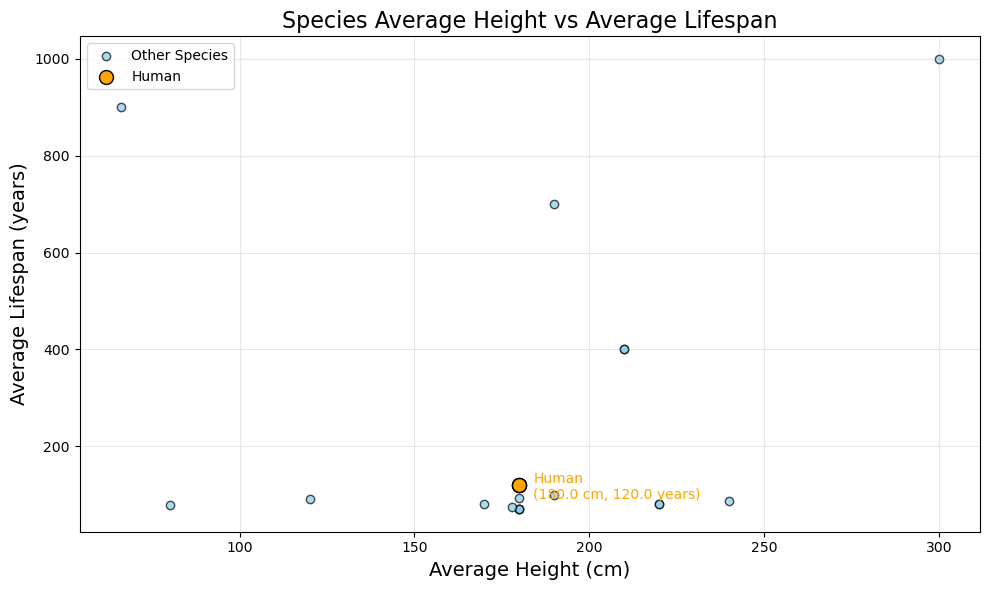

In [167]:
def plot_height_vs_lifespan(species_df, highlight_species=None):
    # Convert 'average_lifespan' and 'average_height' to numeric, ignoring errors for non-numeric values
    species_df['average_lifespan'] = pd.to_numeric(species_df['average_lifespan'], errors='coerce')
    species_df['average_height'] = pd.to_numeric(species_df['average_height'], errors='coerce')

    # Drop rows with missing or invalid values in 'average_lifespan' or 'average_height'
    species_df_cleaned = species_df.dropna(subset=['average_lifespan', 'average_height'])

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(
        species_df_cleaned['average_height'], 
        species_df_cleaned['average_lifespan'], 
        color='skyblue', 
        edgecolor='black', 
        alpha=0.7, 
        label='Other Species'
    )

    # Highlight specific species if provided
    if highlight_species and highlight_species in species_df_cleaned['name'].values:
        highlight_row = species_df_cleaned[species_df_cleaned['name'] == highlight_species]
        plt.scatter(
            highlight_row['average_height'], 
            highlight_row['average_lifespan'], 
            color='orange', 
            edgecolor='black', 
            s=100,  # Larger marker size for emphasis
            label=f'{highlight_species}'
        )
        # Add annotation for the highlighted species
        plt.annotate(
            f"{highlight_species}\n({highlight_row['average_height'].values[0]} cm, {highlight_row['average_lifespan'].values[0]} years)",
            (highlight_row['average_height'].values[0], highlight_row['average_lifespan'].values[0]),
            textcoords="offset points",
            xytext=(10, -10),  # Offset for the annotation
            ha='left',
            fontsize=10,
            color='orange'
        )

    # Add labels, title, legend, and grid
    plt.title('Species Average Height vs Average Lifespan', fontsize=16)
    plt.xlabel('Average Height (cm)', fontsize=14)
    plt.ylabel('Average Lifespan (years)', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example Usage: Highlight Human
plot_height_vs_lifespan(species_df, highlight_species='Human')

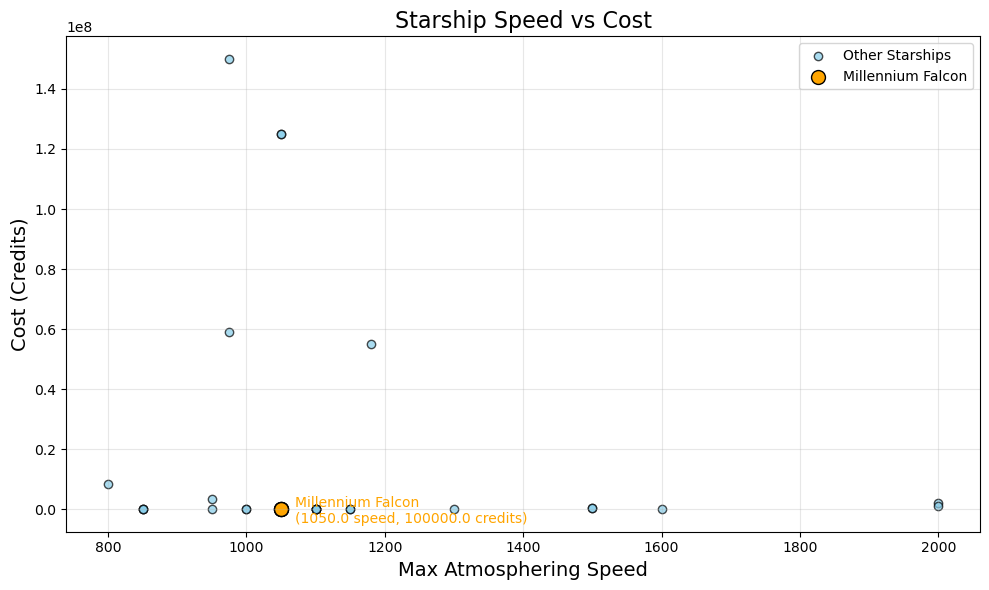

In [168]:
def plot_speed_vs_cost(starships_df, highlight_starship=None):
    # Convert 'cost_in_credits' and 'max_atmosphering_speed' to numeric, ignoring errors for non-numeric values
    starships_df['cost_in_credits'] = pd.to_numeric(starships_df['cost_in_credits'], errors='coerce')
    starships_df['max_atmosphering_speed'] = pd.to_numeric(starships_df['max_atmosphering_speed'], errors='coerce')

    # Drop rows with missing or invalid values in 'cost_in_credits' or 'max_atmosphering_speed'
    starships_df_cleaned = starships_df.dropna(subset=['cost_in_credits', 'max_atmosphering_speed'])

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(
        starships_df_cleaned['max_atmosphering_speed'], 
        starships_df_cleaned['cost_in_credits'], 
        color='skyblue', 
        edgecolor='black', 
        alpha=0.7, 
        label='Other Starships'
    )

    # Highlight specific starship if provided
    if highlight_starship and highlight_starship in starships_df_cleaned['name'].values:
        highlight_row = starships_df_cleaned[starships_df_cleaned['name'] == highlight_starship]
        plt.scatter(
            highlight_row['max_atmosphering_speed'], 
            highlight_row['cost_in_credits'], 
            color='orange', 
            edgecolor='black', 
            s=100,  # Larger marker size for emphasis
            label=f'{highlight_starship}'
        )
        # Add annotation for the highlighted starship
        plt.annotate(
            f"{highlight_starship}\n({highlight_row['max_atmosphering_speed'].values[0]} speed, {highlight_row['cost_in_credits'].values[0]} credits)",
            (highlight_row['max_atmosphering_speed'].values[0], highlight_row['cost_in_credits'].values[0]),
            textcoords="offset points",
            xytext=(10, -10),  # Offset for the annotation
            ha='left',
            fontsize=10,
            color='orange'
        )

    # Add labels, title, legend, and grid
    plt.title('Starship Speed vs Cost', fontsize=16)
    plt.xlabel('Max Atmosphering Speed', fontsize=14)
    plt.ylabel('Cost (Credits)', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example Usage: Highlight Millennium Falcon
plot_speed_vs_cost(starships_df, highlight_starship='Millennium Falcon')

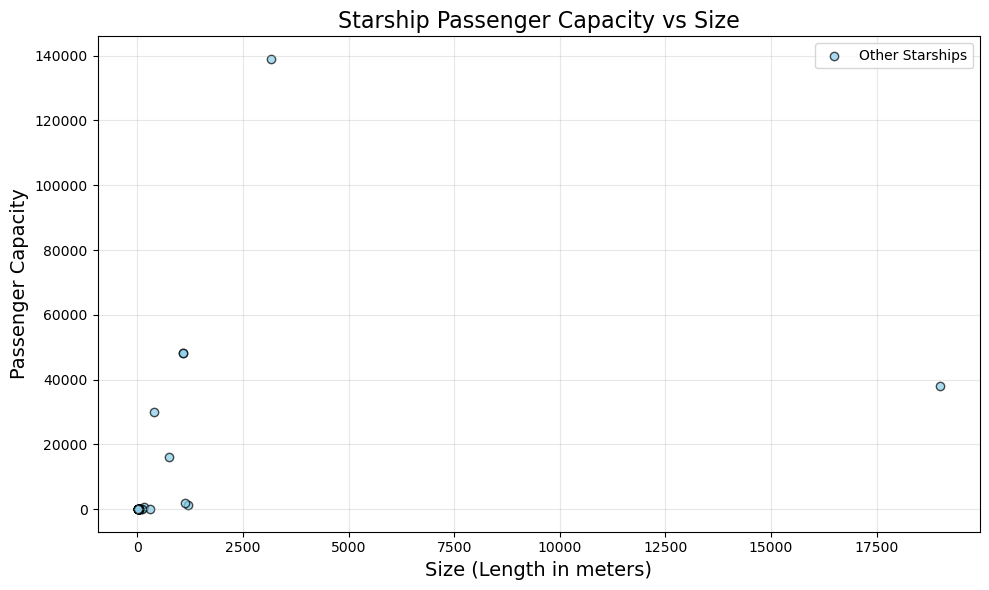

In [169]:
def plot_passenger_capacity_vs_size(starships_df, highlight_starship=None):
    # Convert 'passengers' and 'length' to numeric, ignoring errors for non-numeric values
    starships_df['passengers'] = pd.to_numeric(starships_df['passengers'], errors='coerce')
    starships_df['length'] = pd.to_numeric(starships_df['length'], errors='coerce')

    # Drop rows with missing or invalid values in 'passengers' or 'length'
    starships_df_cleaned = starships_df.dropna(subset=['passengers', 'length'])

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(
        starships_df_cleaned['length'], 
        starships_df_cleaned['passengers'], 
        color='skyblue', 
        edgecolor='black', 
        alpha=0.7, 
        label='Other Starships'
    )

    # Highlight specific starship if provided
    if highlight_starship and highlight_starship in starships_df_cleaned['name'].values:
        highlight_row = starships_df_cleaned[starships_df_cleaned['name'] == highlight_starship]
        plt.scatter(
            highlight_row['length'], 
            highlight_row['passengers'], 
            color='orange', 
            edgecolor='black', 
            s=100,  # Larger marker size for emphasis
            label=f'{highlight_starship}'
        )
        # Add annotation for the highlighted starship
        plt.annotate(
            f"{highlight_starship}\n({highlight_row['length'].values[0]} m, {highlight_row['passengers'].values[0]} passengers)",
            (highlight_row['length'].values[0], highlight_row['passengers'].values[0]),
            textcoords="offset points",
            xytext=(10, -10),  # Offset for the annotation
            ha='left',
            fontsize=10,
            color='orange'
        )

    # Add labels, title, legend, and grid
    plt.title('Starship Passenger Capacity vs Size', fontsize=16)
    plt.xlabel('Size (Length in meters)', fontsize=14)
    plt.ylabel('Passenger Capacity', fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example Usage: Highlight Star Destroyer
plot_passenger_capacity_vs_size(starships_df, highlight_starship='Star Destroyer')
